# KPP test stand efficiency analysis 

In [1]:
# External libraries
import sys
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Mu2e pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyprint 
import pyplot 

pr = pyprint.Print()
pl = pyplot.Plot()

# anapytools
from anapytools.read_data import DataReader
reader = DataReader()

# EffAna methods
sys.path.append("../Utils")
from processor import Processor # process rec trees into ak
from crvaging019 import CrvAging019 # get PEs/layer for crvaging-019
from cuts import Cuts # Apply cuts
from trigger import Trigger # Trigger
from sort import Sort # Sort PEs / layer
from histogrammer import Histogrammer # Accumulate histograms 
from scan_inefficiency import ScanInefficiency # Analyse inefficiency

## Process data

In [2]:
# Initialise
reader = DataReader()
processor = Processor(reader=reader)

# Configure dataset
defname = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root"
run_number="002101"

# Get filelist
filelist = processor.get_filelist(defname, run_number)

# Process files
arrays = processor.process_files_parallel(filelist)
# arrays = processor.process_files_parallel(['rec.mu2e./CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root'])
# Print array info
arrays.type.show()
print("→ FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print("→ Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

---> Loading Processor...
filelist: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root']

---> Starting parallel processing with 5 workers...
Processing 5 files in total

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root processed successfully!
  → Events in this file: 154878
  → Progress: 1/5 files (20.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root processed successfully!
  → Events in this file: 157287
  → Progress: 2/5 files (40.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root processed successfully!
  → Events in this file: 156933
  → Progress: 3/5 files (60.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root processed succe

## Get PEs/layer

In [3]:
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T()
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...

---> Mapping CRV-L-end
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

773205 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    subrun: int64,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 1.25, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
subrun: 3
PEs_per_layer_L_end: [[0, 0, 0.617, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0.866, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 

## Apply cuts


---> Loading Cuts...
Initial number of events: 773205


/home/sgrant/Wideband/Notebooks/../EventNtuple/utils/pyutils/pyplot.py:187: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin, xmax)


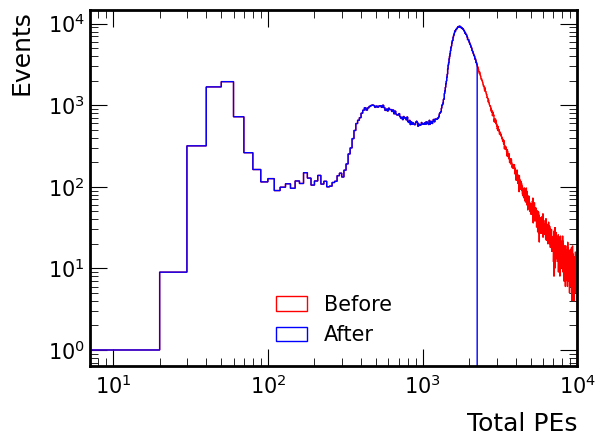


Total PE cut (< 2250):
Events removed: 164394 (21.3%)
Events remaining: 608811 (78.7% of initial)


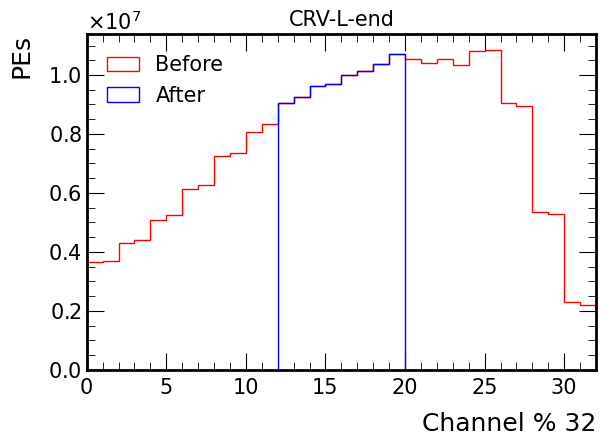


Fiducial cut (channels 12-19):


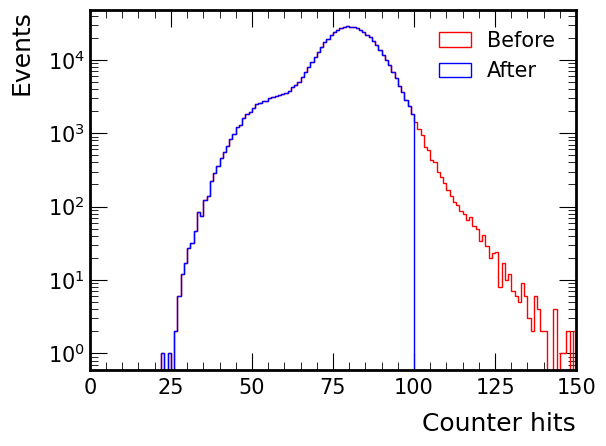


Counters hit cut (≤ 100):
Events removed: 7537 (1.2%)
Events remaining: 601274 (77.8% of initial)


In [4]:
cuts = Cuts(arrays, verbose=True)

max_PEs = 2250
# 0,1,2,3 4,5,6,7 8,9,10,11 12,13,14,15 16,17,18,19 20,21,22,23 24,25,26,27, 28,29,30,31
lo_chan=12
hi_chan=19
min_counter_hits=8*2
max_counter_hits=100

arrays_cut = cuts.tot_PE_cut(max_PEs=max_PEs)
arrays_cut = cuts.fiducial_cut(lo_chan=lo_chan, hi_chan=hi_chan) 
arrays_cut = cuts.counters_hit_cut(min_counter_hits=min_counter_hits, max_counter_hits=max_counter_hits)

In [5]:
## Plot cut parameters here

## Trigger

In [6]:
trigger = Trigger(arrays)
arrays_cut = trigger.get_triggers()
# Exclude events with no trigger:
arrays_cut = arrays_cut[arrays_cut['trig']]


---> Loading Trigger...
---> Triggering
-> 626192/773205 = 80.99% events have triggers


In [7]:
# # for treename in reader.treenames_:
pr.PrintNEvents(arrays_cut, 5)


---> Printing 5 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 1.25, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
subrun: 3
PEs_per_layer_L_end: [[0, 0, 0.617, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0.866, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 0, 0, 0.956, 0, 0, 0, 0, 0, 0, ..., 0, 0, 1.25, 0, 0, 0, 0, 0, 0, 0], ...]
trig_L_end_layers: [1, 1, 1, 1]
trig_DS_layers: [1, 1, 1, 1]
trig_L_end: True
trig_DS: True
trig: True
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
eventNumber: 2
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 85.9, 63.3, 0, 0], ...]
subrun: 3
PEs_per_layer_L_end: [[0.93, 0, 0, 0, 0, 0, 0, 0, 0, .

## Sort PEs in test module

In [8]:
sort = Sort()
arrays_cut["PEs_per_layer_T_sorted"] = sort.sort_layer_PEs(arrays_cut['PEs_per_layer_T'])

print("Sorted PEs:")
for i_event in range(10): 
    print(i_event, arrays_cut['PEs_per_layer_T_sorted'][i_event])
print("...")

---> Loading Sort...
Sorted PEs:
0 [124, 125, 126, 136]
1 [80.9, 91.9, 106, 109]
2 [84.6, 98, 109, 119]
3 [89.4, 145, 168, 174]
4 [40.2, 72, 103, 112]
5 [97.8, 103, 112, 117]
6 [115, 138, 169, 179]
7 [101, 112, 130, 151]
8 [91.5, 98.1, 118, 193]
9 [81.7, 106, 127, 263]
...


In [9]:
# Histogram PEs per layer, sorted accorded to the lowest total PEs in each layer 
def sort_layer_PEs(array):
    """
    Sort PEs per layer within each event.
    Input: [events, layer, channel]
    Output: [events, layer] where layers are sorted by total PEs
    """
    # Sum channels for each layer 
    layer_sums = ak.sum(array, axis=-1)  # Shape: [events, layer]
    
    # Sort layer sums within each event
    sorted_layers = ak.sort(layer_sums, axis=-1)  # Shape: [events, layer] 
    
    return sorted_layers
        
# Sort 
# arrays['PEs_per_layer_L_end_fid_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end_fid'])
# arrays['PEs_per_layer_L_end_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
arrays_cut['PEs_per_layer_T_sorted'] = sort_layer_PEs(arrays_cut['PEs_per_layer_T'])
# arrays['PEs_per_layer_DS_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
print("Sorted PEs:")
for i_event in range(10): 
    print(i_event, arrays_cut['PEs_per_layer_T_sorted'][i_event])
print("...")

Sorted PEs:
0 [124, 125, 126, 136]
1 [80.9, 91.9, 106, 109]
2 [84.6, 98, 109, 119]
3 [89.4, 145, 168, 174]
4 [40.2, 72, 103, 112]
5 [97.8, 103, 112, 117]
6 [115, 138, 169, 179]
7 [101, 112, 130, 151]
8 [91.5, 98.1, 118, 193]
9 [81.7, 106, 127, 263]
...


## Method 1: sorted PEs/layer histograms

---> Loading Hists...


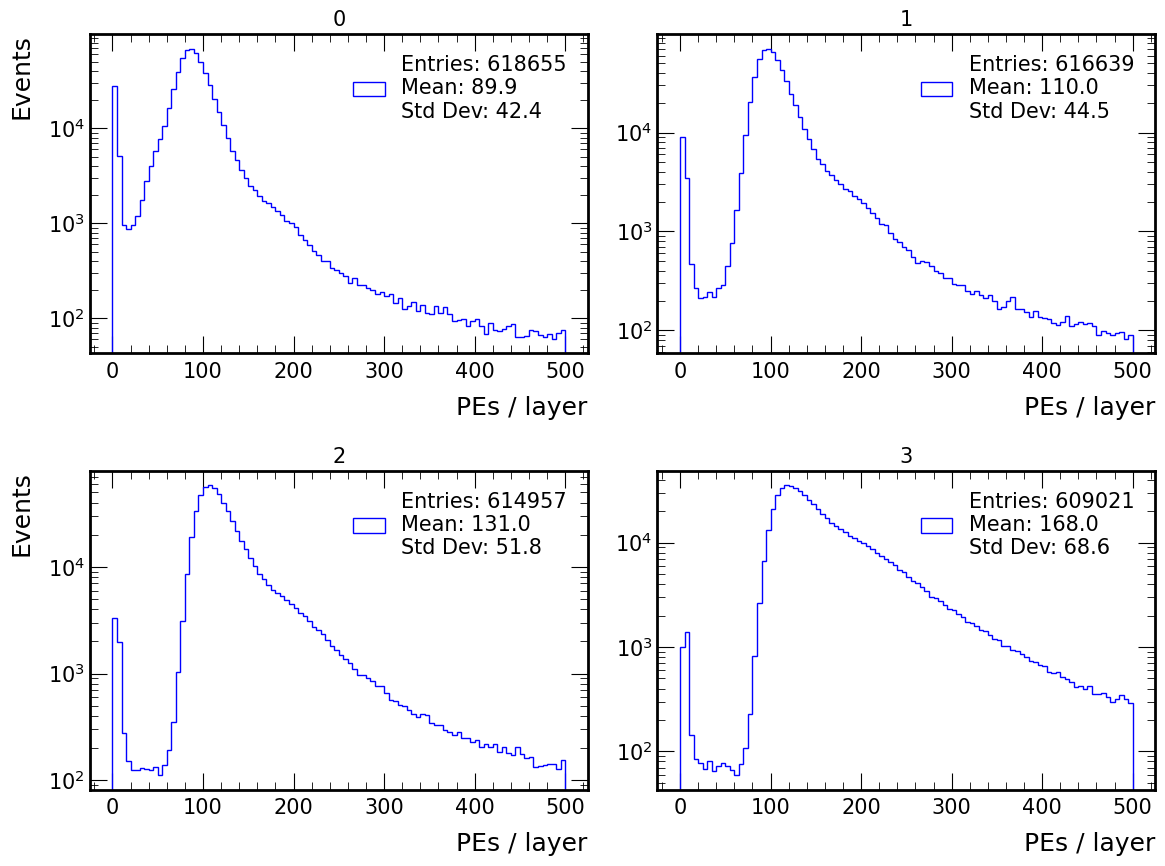

In [10]:
# Probably the fasted for scanning thresholds?
# The problem is that you loose all the event number information in the histograms
# Not sure if needed?

histogrammer = Histogrammer()
hists = histogrammer.acc_hists(arrays_cut)

fig, ax = plt.subplots(2, 2, figsize=(1.5*8, 1.5*6))

for i_sort in range(len(hists)):
    
    # Convert i_sort to 2D index
    row = i_sort // 2
    col = i_sort % 2

    # Get histogram data
    counts = hists[i_sort]['counts']
    bin_edges = hists[i_sort]['bin_edges']
    bin_centres = (bin_edges[1:] + bin_edges[:-1])/2
    
    # Calculate stats
    n_entries = np.sum(counts)
    mean = np.sum(counts * bin_centres) / n_entries
    std_dev = np.sqrt(np.sum(counts * (bin_centres - mean)**2) / n_entries)
    
    # Plot histogram using bin edges and counts
    hist = ax[row,col].hist(
        x=hists[i_sort]['bin_edges'][:-1],  # Use left edges of bins
        bins=hists[i_sort]['bin_edges'],
        weights=hists[i_sort]['counts'],
        histtype='step',
        color='blue',
        log=True,
        label=f"Entries: {int(n_entries)}\nMean: {pl.RoundToSigFig(mean, 3)}\nStd Dev: {pl.RoundToSigFig(std_dev, 3)}"
    )

    ax[row,col].set_title(i_sort)
    ax[row,col].set_xlabel("PEs / layer")
    ax[row,col].set_ylabel("Events" if col == 0 else "")
    # ax[row,col].grid(True, alpha=0.7)
    ax[row,col].legend(loc="upper right")
    
plt.tight_layout()
plt.savefig("../Images/EffAna/h1_sortedPEs.png")
plt.show()


## Method 2: direct array operations

In [11]:
print(arrays_cut["PEs_per_layer_T_sorted"][:])
print(arrays_cut["PEs_per_layer_T_sorted"][:,0])

[[124, 125, 126, 136], [80.9, 91.9, 106, 109], ..., [84.2, 100, 101, 102]]
[124, 80.9, 84.6, 89.4, 40.2, 97.8, 115, ..., 134, 95.6, 74.6, 79.8, 108, 84.2]


In [12]:
# # This preserves the event information, so is good for debugging 
# # I think this is just far better tbh, but keep method 1 as backup

# def get_failures(arrays, thresholds=[10]):
#     for thres in thresholds:
#         arrays[f"fail_{thres}"] = ak.values_astype((arrays["PEs_per_layer_T_sorted"] < thres), "int") 
#     return arrays

# thresholds = np.linspace(10, 150, 29)
# print(thresholds)
# arrays_cut_copy = ak.copy(arrays_cut)
# arrays_cut_copy = get_failures(arrays_cut_copy, thresholds=thresholds)
# pr.PrintNEvents(arrays_cut_copy)

# Scan inefficiency 

In [13]:
from statsmodels.stats.proportion import proportion_confint

class ScanInefficiency:
    def __init__(self, start=10, stop=150, steps=29, verbose=True):
        """Initialise inefficiency scanner 
        Args:
            start (int): starting threshold
            stop (int): ending threshold
            steps (int): number of scan points
            verbose (bool): printouts 
        """
        print("---> Loading Inefficiency...")
        # Validate inputs
        if stop <= start:
            raise ValueError("'stop' must be greater than 'start'")
        if steps < 2:
            raise ValueError("'steps' must be >= 2")
        self.start = start
        self.stop = stop
        self.steps = steps
        self.n_layers = 4 # Number of layers/module
        # Create scan points
        self.thresholds = np.linspace(self.start, self.stop, self.steps)
        if verbose: 
            print(f"PE thresholds to scan\n: {self.thresholds}")        

    def get_ineff(self, k, N):
        """Calculate inefficiency
        
        Args:
            k (int): Number of failures
            N (int): Total number of triggers
        
        Returns:
            float: inefficiency (float)
        """
        return k / N if N > 0 else 0

    def get_ineff_err(self, k, N, conservative=True):
        """Calculate Wilson confidence interval for proportion
        
        Args:
            k (int): Number of failures
            N (int): Total number of trials
            conservative (bool): If True, use upper bound difference
        
        Returns:
            float: Uncertainty estimate
            
        Raises:
            ValueError: If k > N or if either is negative
        """
        if k > N or k < 0 or N < 0:
            raise ValueError("Invalid k or N values")
            
        lower, upper = proportion_confint(k, N, method="wilson")
        point = k/N
        
        if conservative:
            return abs((upper - point) / 2)
        else:
            return abs((lower - point) / 2)

    def _create_result_arrays(self):
        """Create fresh arrays for storing results"""
        ineff = {i: np.zeros(self.steps) for i in range(self.n_layers)}
        ineff_err = {i: np.zeros(self.steps) for i in range(self.n_layers)}
        return ineff, ineff_err
        
    def scan_ineff_arrays(self, arrays):
        """Scan array to calculate inefficiency at different PE thresholds
        
        Args:
            arrays: awkward array containing triggered and sorted PEs in test module
            
        Returns:
            tuple: (x, y, yerr)
                x: PE threshold values as list
                y: Inefficiency values as dict (keys are sorted layer indices)
                yerr: Inefficiency uncertainty as dict (keys are sorted layer indices)
        """
        # Get result arrays
        ineff, ineff_err = self._create_result_arrays()
        # Total triggers
        N = len(arrays)
        # For each scan point
        for i_thres, thres in enumerate(self.thresholds):
            # Mark failures 
            arrays[f"fail_{thres}"] = ak.values_astype((arrays["PEs_per_layer_T_sorted"] < thres), "int") 
            # For i/4 layers
            for i_layer in range(self.n_layers):
                # Get failures 
                k = ak.sum(arrays[f"fail_{thres}"][:,i_layer], axis=None)
                # Get and store inefficiency
                ineff[i_layer][i_thres] = self.get_ineff(k, N)
                # Get and store uncertainty on inefficiency
                ineff_err[i_layer][i_thres] = self.get_ineff_err(k, N)
        return self.thresholds, ineff, ineff_err 

    def scan_ineff_hists(self, hists):
        """Scan histogram to calculate inefficiency at different PE thresholds
        
        Args:
            hists (dict): Sorted PE/layer histograms
            
        Returns:
            tuple: (x, y, yerr)
                x: PE threshold values as list
                y: Inefficiency values as dict (keys are sorted layer indices)
                yerr: Inefficiency uncertainty as dict (keys are sorted layer indices)
        """
        # Get result arrays
        ineff, ineff_err = self._create_result_arrays()

        for i_layer in range(self.n_layers):
        
            counts = hists[i_layer]['counts']
            bin_edges = hists[i_layer]['bin_edges']
            N = np.sum(counts)
            
            # For each scan point
            for i_thres, thres in enumerate(self.thresholds):
                # Find bins below threshold
                mask = bin_edges[:-1] < thres
                k = np.sum(counts[mask])
                
                # Calculate inefficiency
                ineff[i_layer][i_thres] = k / N if N > 0 else 0
                # Calculate uncertainty using instance method
                ineff_err[i_layer][i_thres] = self.get_ineff_err(k, N)
    
        return self.thresholds, ineff, ineff_err 

    def plot_scan(self, ineff, ineff_err, title=None, fout=None):
        """  
          Plot inefficiency scan 
        """  
        # Create figure and axes
        fig, ax = plt.subplots()

        # Loop through graphs and plot
        for i_layer in range(self.n_layers): 
            # Create this graph
            ax.errorbar(
              x=self.thresholds, y=ineff[i_layer], yerr=ineff_err[i_layer], label=f"{self.n_layers-i_layer}/4 layers",
              fmt='o', markersize=4, capsize=2, elinewidth=1
            )
        # Set log-y scale
        ax.set_yscale("log")

        # Titles
        ax.set_title(title)
        ax.set_ylabel("Inefficiency")
        ax.set_xlabel("PE threshold")

        # Legend
        ax.legend(loc="best")

        # Draw inefficiency line
        ax.axhline(y=1e-4, color='gray', linestyle='--')
        ax.text(90, 0.33e-4, "99.99% efficiency", color="gray", fontsize="small") 

        # Draw
        plt.tight_layout()
    
        # Save 
        if fout:
          plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
          print("\n---> Wrote:\n\t", fout)
            
        # Show
        plt.show()

---> Loading Inefficiency...
PE thresholds to scan
: [ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150.]


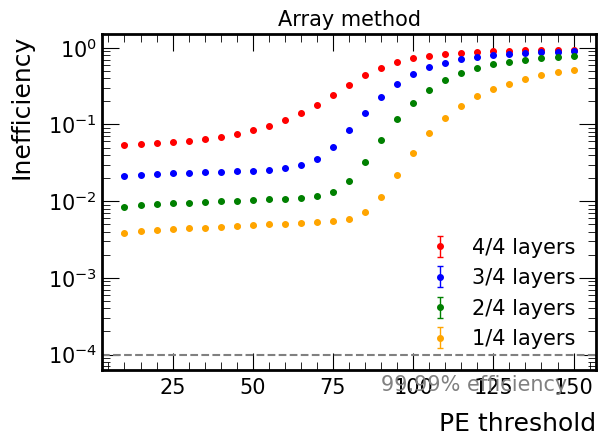

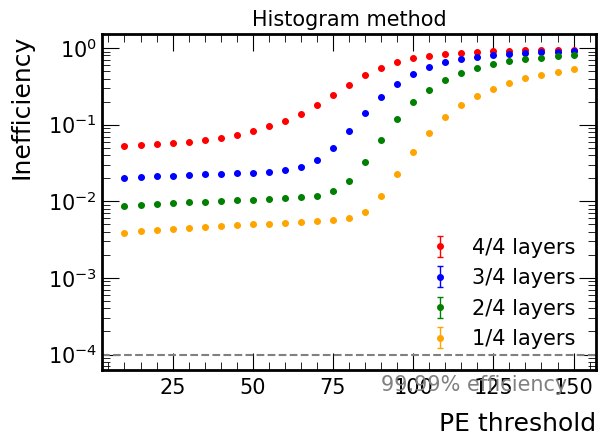

In [14]:
inefficiency = ScanInefficiency()

# Array method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays_cut)
inefficiency.plot_scan(ineff, ineff_err, title="Array method")

# Histogram method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
inefficiency.plot_scan(ineff, ineff_err, title="Histogram method")

In [15]:
# pl.PlotGraphOverlay( 
#     {
#         '1/4 layers' : [thresholds, ineff[0], None, ineff_err[0]],
#         '2/4 layers' : [thresholds, ineff[1], None, ineff_err[1]],
#         '3/4 layers' : [thresholds, ineff[2], None, ineff_err[2]],
#         '4/4 layers' : [thresholds, ineff[3], None, ineff_err[3]],
#     },
#     xlabel='PE threshold', ylabel='Inefficiency', 
#     y_lines = [1e-4], log_y=True,
#     save=True, fout='../Images/EffAna/gro_ineff.png'
# )

In [16]:
# inefficiency = Inefficiency()

# # print(hists)
# # thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
# # x_44, y_44, yerr_44 = inefficiency.scan_ineff_hists(hists[0]) 
# # x_34, y_34, yerr_34 = inefficiency.scan_ineff_hists(hists[1])
# # x_24, y_24, yerr_24 = inefficiency.scan_ineff_hists(hists[2]) 
# # x_14, y_14, yerr_14 = inefficiency.scan_ineff_hists(hists[3])

# thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)

# print(ineff)


# pl.PlotGraphOverlay( 
#     {
#         '1/4 layers' : [thresholds, ineff[0], None, ineff_err[0]],
#         '2/4 layers' : [thresholds, ineff[1], None, ineff_err[1]],
#         '3/4 layers' : [thresholds, ineff[2], None, ineff_err[2]],
#         '4/4 layers' : [thresholds, ineff[3], None, ineff_err[3]],
#     },
#     xlabel='PE threshold', ylabel='Inefficiency', 
#     y_lines = [1e-4], log_y=True,
#     save=False, fout='../Images/EffAna/gro_ineff.png'
# )

# # # 
# # print(len(thresholds), len(ineff[0]))

## Trigger

In [17]:
# def get_triggers(arrays, thres=10):
#     """
#     Get triggers from nested PEs/layer arrays.
#     Returns arrays with trigger flags
#     """
#     print("---> Triggering")
    
#     # Sum channels for each layer
#     layer_sums_L_end = ak.sum(arrays['PEs_per_layer_L_end'], axis=-1)  # [events, layer]
#     layer_sums_DS = ak.sum(arrays['PEs_per_layer_DS'], axis=-1)        # [events, layer]
    
#     # Create trigger flags for each layer
#     arrays['trig_L_end_layers'] = ak.values_astype(layer_sums_L_end > thres, 'int')  # [events, layer]
#     arrays['trig_DS_layers'] = ak.values_astype(layer_sums_DS > thres, 'int')        # [events, layer]
    
#     # Check if all layers triggered
#     arrays['trig_L_end'] = ak.values_astype(ak.sum(arrays['trig_L_end_layers'], axis=-1) == 4, 'bool')
#     arrays['trig_DS'] = ak.values_astype(ak.sum(arrays['trig_DS_layers'], axis=-1) == 4, 'bool')
    
#     # Combined trigger requirement
#     arrays['trig'] = (arrays['trig_L_end'] & arrays['trig_DS'])

#     n_tot = len(arrays)
#     n_trig = len(arrays[arrays['trig']])
#     trig_frac = n_trig/n_tot

#     print(f"{n_trig}/{n_tot} = {100*trig_frac:.2f}% events have triggers")

    

# # Apply triggers
# get_triggers(arrays_cut, thres=10)

# # Exclude events with no trigger:
# arrays_cut = arrays_cut[arrays_cut['trig']]

# tot_triggers = len(arrays_cut)

## Sort PEs in test module

In [18]:
# # Histogram PEs per layer, sorted accorded to the lowest total PEs in each layer 
# def sort_layer_PEs(array):
#     """
#     Sort PEs per layer within each event.
#     Input: [events, layer, channel]
#     Output: [events, layer] where layers are sorted by total PEs
#     """
#     # Sum channels for each layer 
#     layer_sums = ak.sum(array, axis=-1)  # Shape: [events, layer]
    
#     # Sort layer sums within each event
#     sorted_layers = ak.sort(layer_sums, axis=-1)  # Shape: [events, layer] 
    
#     return sorted_layers

# # Sort 
# # arrays['PEs_per_layer_L_end_fid_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end_fid'])
# # arrays['PEs_per_layer_L_end_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
# arrays_cut['PEs_per_layer_T_sorted'] = sort_layer_PEs(arrays_cut['PEs_per_layer_T'])
# # arrays['PEs_per_layer_DS_sorted'] = sort_layer_PEs(arrays['PEs_per_layer_L_end'])
# print("Sorted PEs:")
# for i_event in range(10): 
#     print(i_event, arrays_cut['PEs_per_layer_T_sorted'][i_event])
# print("...")

In [19]:
# def init_hists(nbins=100, x_range=(0,500)): # Same range that Yuri uses
#     """
#     Initialise empty histograms for accumulation
#     """
#     hists = {}
#     for i_sort in range(4):
#         # Create empty histogram with metadata
#         hists[i_sort] = {
#             'counts': np.zeros(nbins),
#             'bin_edges': np.linspace(x_range[0], x_range[1], nbins + 1),
#             'n_fills': 0
#         }
#     return hists

# def acc_hists(arrays, hists):
#     """
#     Accumulate histograms of sorted PEs/layer.
#     Arrays: input data arrays.
#     Histograms: existing histogram dictionary (if None, will be initialised)
#     """
#     # Initialise if not exists
#     if hists is None:
#         hists = init_hists()
    
#     for i_sort in range(4):
#         # Get flattened array for this sort index
#         array = ak.to_numpy(
#             ak.flatten(arrays['PEs_per_layer_T_sorted'][:,i_sort], axis=None)
#         )
        
#         # Create histogram data
#         counts, _ = np.histogram(
#             array, 
#             bins=hists[i_sort]['bin_edges'],  # Use existing bin edges
#         )

#         # Accumulate counts
#         hists[i_sort]['counts'] += counts
#         hists[i_sort]['n_fills'] += 1
    
#     return hists

# hists = None 

# # Fill from multiple files/threads
# hists = acc_hists(arrays_cut, hists)
# # etc...

In [20]:
# fig, ax = plt.subplots(2, 2, figsize=(1.5*8, 1.5*6))
# # fig, ax2 = plt.subplots() 
# # fig.suptitle("Fill", fontsize=14, y=1.02)

# for i_sort in range(len(hists)):
    
#     # Convert i_sort to 2D index
#     row = i_sort // 2
#     col = i_sort % 2

#     # Get histogram data
#     counts = hists[i_sort]['counts']
#     bin_edges = hists[i_sort]['bin_edges']
#     bin_centres = (bin_edges[1:] + bin_edges[:-1])/2
    
#     # Calculate stats
#     n_entries = np.sum(counts)
#     mean = np.sum(counts * bin_centres) / n_entries
#     std_dev = np.sqrt(np.sum(counts * (bin_centres - mean)**2) / n_entries)
    
#     # Plot histogram using bin edges and counts
#     hist = ax[row,col].hist(
#         x=hists[i_sort]['bin_edges'][:-1],  # Use left edges of bins
#         bins=hists[i_sort]['bin_edges'],
#         weights=hists[i_sort]['counts'],
#         histtype='step',
#         color='blue',
#         log=True,
#         label=f"Entries: {int(n_entries)}\nMean: {pl.RoundToSigFig(mean, 3)}\nStd Dev: {pl.RoundToSigFig(std_dev, 3)}"
#     )

#     ax[row,col].set_title(i_sort)
#     ax[row,col].set_xlabel("PEs / layer")
#     ax[row,col].set_ylabel("Events" if col == 0 else "")
#     # ax[row,col].grid(True, alpha=0.7)
#     ax[row,col].legend(loc="upper right")
    
# plt.tight_layout()
# plt.savefig("../Images/EffAna/h1_sortedPEs.png")
# plt.show()

## Scan inefficiency 

In [21]:
# # Uncertainty 
# from statsmodels.stats.proportion import proportion_confint

# # k: n_failures, N: n_triggers
# def wilson_unc(k, N, conservative=True): 
#     lower, upper = proportion_confint(k, N, method="wilson")
#     point = k/N
#     if conservative: 
#         return abs((upper - point) / 2)
#     else:
#         return abs((lower - point) / 2)

# def scan_ineff(hist, start=10, end=150, steps=15):
#     """
#     Scan histogram to calculate inefficiency at different PE thresholds
    
#     Parameters:
#     hist: histogram dictionary with 'counts' and 'bin_edges'
#     start: start value for scan
#     end: end value for scan
#     steps: number of points 
#     threshold: initial PE threshold
    
#     Returns:
#     x: scan points
#     y: inefficiency values (fraction of entries below threshold)
#     """
#     # Create scan points
#     scan = np.linspace(start, end, steps)
#     # Initialise x and y
#     x = []
#     y = []
#     yerr = []
    
#     counts = hist['counts']
#     bin_edges = hist['bin_edges']
#     tot_counts = np.sum(counts)
    
#     # For each scan point
#     for thres in scan:
#         # Find bins below threshold
#         mask = bin_edges[:-1] < thres
#         failures = np.sum(counts[mask])
        
#         # Calculate inefficiency
#         ineff = failures / tot_counts if tot_counts > 0 else 0 
#         # Error
#         ineff_err = wilson_unc(failures, tot_counts)
        
#         x.append(thres)
#         y.append(ineff)
#         yerr.append(ineff_err)

#     return x, y, yerr

# # fig, ax = plt.subplots() 
# x_44, y_44, yerr_44 = scan_ineff(hists[0], 10, 150, 29)
# x_34, y_34, yerr_34 = scan_ineff(hists[1], 10, 150, 29)
# x_24, y_24, yerr_24 = scan_ineff(hists[2], 10, 150, 29)
# x_14, y_14, yerr_14 = scan_ineff(hists[3], 10, 150, 29)

# # pl.PlotGraph( 
# #     x=x_34, y=y_34, yerr=yerr_34,
# #     xlabel='PE threshold', ylabel='Inefficiency',  log_y=True,
# #     save=True, fout='../Images/gr_ineff_34.png'
# # )

# pl.PlotGraphOverlay( 
#     {
#         '1/4 layers' : [x_14, y_14, None, yerr_14],
#         '2/4 layers' : [x_24, y_24, None, yerr_24],
#         '3/4 layers' : [x_34, y_34, None, yerr_34],
#         '4/4 layers' : [x_44, y_44, None, yerr_44],
#     },
#     xlabel='PE threshold', ylabel='Inefficiency', 
#     y_lines = [1e-4], log_y=True,
#     save=True, fout='../Images/EffAna/gro_ineff.png'
# )

In [22]:
# arrays.fields